# Embedding Analysis

- References:
  - https://umap-learn.readthedocs.io/en/latest/
  - https://hdbscan.readthedocs.io/en/latest/index.html
  - https://www.sbert.net/

In [1]:
%load_ext autoreload
%autoreload 2

In [115]:
import os
import pickle
import random
from tqdm.notebook import tqdm
from collections import Counter, defaultdict

import torch
import numpy as np

from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from sentence_transformers import SentenceTransformer
from datasets import load_dataset, Dataset

from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans

from sibyl import *

import seaborn as sns
import matplotlib.pyplot as plt

In [133]:
torch.use_deterministic_algorithms(False)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

### Dataset

In [3]:
dataset = load_dataset("glue", "sst2", split="train")
dataset = dataset.rename_column("sentence", "text")
original_text, original_labels = dataset['text'], dataset['label']

Found cached dataset glue (C:/Users/Fabrice/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


### Featurizer

In [5]:
embedder   = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedder.encode(original_text, show_progress_bar=True)

Batches:   0%|          | 0/2105 [00:00<?, ?it/s]

In [17]:
umap_fn         = UMAP(n_neighbors=15, n_components=10, metric='cosine')
umap_embeddings = umap_fn.fit_transform(embeddings)

In [20]:
clusterer = KMeans(n_clusters=40)
clusterer.fit(umap_embeddings)

# clusterer = HDBSCAN(min_cluster_size=15)
# clusterer.fit(umap_embeddings)

KMeans(n_clusters=40, random_state=0)

### Model

In [24]:
pipe = pipeline(task="sentiment-analysis", device=0)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


### Transforms

In [105]:
blacklist = [Concept2Sentence, ConceptMix, Emojify]
ts = [t(task_name="sentiment", return_metadata=True) for t in TRANSFORMATIONS if t not in blacklist]

### Analysis

In [22]:
from sibyl import acc_at_k
from sklearn.metrics import accuracy_score

In [28]:
def ohe_label(example):
    example["label"] = one_hot_encode(example["label"], 2)
    return example

def extract_probs(results):
    return np.array([[1-r['score'], r['score']] if r['label'] == "POSITIVE" else [r['score'], 1-r['score']] for r in results])

def compute_accuracy(predictions, labels):
    if len(labels.shape) > 1:
        acc = acc_at_k(labels, predictions, k=2)       
    else:
        acc = accuracy_score(labels, np.argmax(predictions, -1))
    return acc

In [107]:
class EmbeddedClusterFeature:
    def __init__(self, 
                 dataset, 
                 clusters=None,
                 num_clusters=40, 
                 min_samples=5, 
                 embedder=None, 
                 reducer=None, 
                 clusterer=None):
        self.dataset = dataset    
        self.clusters = clusters
        self.num_clusters = num_clusters
        self.min_samples = min_samples
        self.embedder = embedder if embedder else SentenceTransformer('all-MiniLM-L6-v2')
        self.reducer = reducer if reducer else UMAP(n_neighbors=15, n_components=10, metric='cosine', verbose=True)  
        self.clusterer = clusterer if clusterer else KMeans(n_clusters=self.num_clusters, verbose=True) 
        
        if self.clusters is None:
            print("Extracting contextual embeddings from text...")
            self.embeddings = self.embedder.encode(dataset['text'], show_progress_bar=True)
            print("Reducing embedding dimensionality...")
            self.reduced_embeddings = self.reducer.fit_transform(self.embeddings)
            print("Clustering reduced embeddings...")
            self.clusterer.fit(self.reduced_embeddings)
            self.clusters = self.clusterer.labels_
    
    def extract_data_containing_cluster(self, cluster_id, max_size=100):
        
        self.cluster_id = cluster_id 
        
        all_t_idx = np.where(self.clusters == cluster_id)[0]
        t_idx = np.random.choice(all_t_idx, max_size)

        all_f_idx = np.where(self.clusters != cluster_id)[0]
        f_idx = np.random.choice(all_f_idx, max_size)

        self.t_dataset = self.dataset.select(t_idx).map(ohe_label)
        self.f_dataset = self.dataset.select(f_idx).map(ohe_label)
            
    def generate_transformed_datasets(self, transform):
        
        self.transform = transform
         
        # apply transformation to each set of texts containing the target feature
        transformed_t_text, transformed_t_labels = transform.transform_batch(
            batch=(self.t_dataset['text'], self.t_dataset['label']))
        transformed_f_text, transformed_f_labels = transform.transform_batch(
            batch=(self.f_dataset['text'], self.f_dataset['label']))
        transformed_t_labels = np.stack([np.array(a).squeeze() for a in transformed_t_labels])
        transformed_f_labels = np.stack([np.array(a).squeeze() for a in transformed_f_labels])
        
        self.tran_t_dataset = Dataset.from_list(
            [{'text': t, 'label': l} for t, l in zip(transformed_t_text, transformed_t_labels)])
        self.tran_f_dataset = Dataset.from_list(
            [{'text': t, 'label': l} for t, l in zip(transformed_f_text, transformed_f_labels)]) 
        
        self.t_changed = sum([t1 != t2 for t1, t2 in zip(self.t_dataset, self.tran_t_dataset)]) / len(self.t_dataset['text'])
        self.f_changed = sum([t1 != t2 for t1, t2 in zip(self.f_dataset, self.tran_f_dataset)]) / len(self.f_dataset['text'])
    
    def evaluate_original(self, pipe):
        
        # pass data through the model
        self.orig_t_preds = extract_probs(pipe(KeyDataset(self.t_dataset, "text")))
        self.orig_f_preds = extract_probs(pipe(KeyDataset(self.f_dataset, "text")))
        
        # compute accuracy
        self.orig_t_acc = compute_accuracy(
            self.orig_t_preds, np.argmax(self.t_dataset['label'], -1))
        self.orig_f_acc = compute_accuracy(
            self.orig_f_preds, np.argmax(self.f_dataset['label'], -1))
        
        results = {
            "transform": "original",
            "cluster_id": self.cluster_id,
            "num_samples": len(self.t_dataset),
            "T_orig_acc": self.orig_t_acc,
            "F_orig_acc": self.orig_f_acc,
            "T_tran_acc": 0,
            "F_tran_acc": 0,
            "T_changed": 0,
            "F_changed": 0
        }
        
        return results
            
    def evaluate_transform(self, pipe):
               
        # pass data through the model
        self.tran_t_preds = extract_probs(pipe(KeyDataset(self.tran_t_dataset, "text")))
        self.tran_f_preds = extract_probs(pipe(KeyDataset(self.tran_f_dataset, "text")))
        
        # compute accuracy
        self.tran_t_acc = compute_accuracy(
            self.tran_t_preds, np.array(self.tran_t_dataset['label']))
        self.tran_f_acc = compute_accuracy(
            self.tran_f_preds, np.array(self.tran_f_dataset['label']))
        
        results = {
            "transform": self.transform.__class__.__name__,
            "cluster_id": self.cluster_id,
            "num_samples": len(self.t_dataset),
            "T_orig_acc": self.orig_t_acc,
            "F_orig_acc": self.orig_f_acc,
            "T_tran_acc": self.tran_t_acc,
            "F_tran_acc": self.tran_f_acc,
            "T_changed": self.t_changed,
            "F_changed": self.f_changed
        }
        
        return results
    
    def get_prediction_details(self):
        # Feature DataFrame: T
        t_df = pd.DataFrame(
            [
                self.t_dataset["text"], 
                self.t_dataset["label"],
                self.orig_t_preds,
                self.tran_t_dataset["text"],
                self.tran_t_dataset["label"],
                self.tran_t_preds,
            ]).T
        t_df.columns = ['orig_t_text', 'orig_t_label', 'orig_t_preds', 
                        'tran_t_text', 'tran_t_label', 'tran_t_preds']
        
        t_df['t_pred_diff'] = t_df.apply(lambda row: np.array(row['orig_t_preds']) - np.array(row['tran_t_preds']), axis=1)

        # Feature DataFrame: F
        f_df = pd.DataFrame(
            [
                self.f_dataset["text"], 
                self.f_dataset["label"],
                self.orig_f_preds,
                self.tran_f_dataset["text"],
                self.tran_f_dataset["label"],
                self.tran_f_preds,
            ]).T
        f_df.columns = ['orig_f_text', 'orig_f_label', 'orig_f_preds', 
                        'tran_f_text', 'tran_f_label', 'tran_f_preds']

        f_df['f_pred_diff'] = f_df.apply(lambda row: np.array(row['orig_f_preds']) - np.array(row['tran_f_preds']), axis=1)
        
        return t_df, f_df

In [109]:
ec = EmbeddedClusterFeature(dataset, clusterer.labels_)

feature_results = {}
for cluster_id in tqdm(range(ec.clusters.max())):
    
    # cluster_id info
    print(f"cluster_id: {cluster_id}")

    # create feature datasets
    ec.extract_data_containing_cluster(cluster_id, 100)
    if not ec.t_dataset:
        continue
    print(f"Dataset Size: {len(ec.t_dataset)}")
    print(f"T Feature: {ec.t_dataset[0]}")
    print(f"F Feature: {ec.f_dataset[0]}")
    
    # evaluation
    results = []
    # evaluate original
    results.append(ec.evaluate_original(pipe))
    # evaluate transformations
    for t in ts:
        ec.generate_transformed_datasets(t)
        result = ec.evaluate_transform(pipe)
        # print(result)
        t_df, f_df = ec.get_prediction_details()
        result['t_df'] = t_df
        result['f_df'] = f_df
        results.append(result)
        
    df = pd.DataFrame(results)
    df['T_diff'] = df['T_orig_acc'] - df['T_tran_acc']
    df['F_diff'] = df['F_orig_acc'] - df['F_tran_acc']
    df["diff_impact"] = abs(df['T_diff'] - df['F_diff'])
        
    feature_results[cluster_id] = df

  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

Cluster_ID: 0


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 3627, 'label': [0.0, 1.0], 'text': "hoffman 's performance is authentic to the core of his being . "}
F Feature: {'idx': 67287, 'label': [0.0, 1.0], 'text': 'is a masterpiece of elegant wit and artifice . '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


  3%|██▏                                                                                | 1/39 [01:09<44:00, 69.48s/it]

Cluster_ID: 1


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 62881, 'label': [0.0, 1.0], 'text': 'is visually smart '}
F Feature: {'idx': 32512, 'label': [1.0, 0.0], 'text': 'has no clue about making a movie '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


  5%|████▎                                                                              | 2/39 [02:20<43:32, 70.62s/it]

Cluster_ID: 2


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 2476, 'label': [0.0, 1.0], 'text': 'a well-written and occasionally challenging social drama '}
F Feature: {'idx': 15737, 'label': [1.0, 0.0], 'text': 'guilt-trip '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


  8%|██████▍                                                                            | 3/39 [03:32<42:40, 71.12s/it]

Cluster_ID: 3


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 43273, 'label': [0.0, 1.0], 'text': ', captures a life interestingly lived '}
F Feature: {'idx': 21834, 'label': [1.0, 0.0], 'text': 'is why film criticism can be considered work . '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 10%|████████▌                                                                          | 4/39 [04:44<41:45, 71.57s/it]

Cluster_ID: 4


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 10437, 'label': [1.0, 0.0], 'text': "'s as if allen , at 66 , has stopped challenging himself . "}
F Feature: {'idx': 20957, 'label': [0.0, 1.0], 'text': 'pull a cohesive story out '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 13%|██████████▋                                                                        | 5/39 [05:54<40:06, 70.77s/it]

Cluster_ID: 5


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 26572, 'label': [0.0, 1.0], 'text': 'consistently funny , in an irresistible junior-high way , '}
F Feature: {'idx': 31502, 'label': [1.0, 0.0], 'text': 'intentionally introducing your kids to films which will cause loads of irreparable damage that years and years of costly analysis could never fix '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 15%|████████████▊                                                                      | 6/39 [07:04<38:45, 70.48s/it]

Cluster_ID: 6


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 23964, 'label': [0.0, 1.0], 'text': "barry 's cold-fish act makes the experience worthwhile "}
F Feature: {'idx': 66132, 'label': [0.0, 1.0], 'text': 'par with the first one '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 18%|██████████████▉                                                                    | 7/39 [08:13<37:18, 69.95s/it]

Cluster_ID: 7


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 12754, 'label': [0.0, 1.0], 'text': 'mention mysterious , sensual , emotionally intense , and replete '}
F Feature: {'idx': 11930, 'label': [0.0, 1.0], 'text': 'find ourselves surprised at how much we care about the story '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 21%|█████████████████                                                                  | 8/39 [09:21<35:56, 69.58s/it]

Cluster_ID: 8


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 4829, 'label': [1.0, 0.0], 'text': 'rushed , slapdash , sequel-for-the-sake - '}
F Feature: {'idx': 59105, 'label': [1.0, 0.0], 'text': "'s nothing resembling a spine here "}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 23%|███████████████████▏                                                               | 9/39 [10:29<34:32, 69.08s/it]

Cluster_ID: 9


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 13870, 'label': [0.0, 1.0], 'text': 'this is a movie that refreshes the mind and spirit along with the body , so original is its content , look , and style '}
F Feature: {'idx': 50951, 'label': [0.0, 1.0], 'text': 'how inseparable the two are '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 26%|█████████████████████                                                             | 10/39 [11:35<32:51, 68.00s/it]

Cluster_ID: 10


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 43545, 'label': [0.0, 1.0], 'text': 'gives us the perfect starting point for a national conversation about guns , violence , and fear '}
F Feature: {'idx': 11051, 'label': [1.0, 0.0], 'text': 'and for all the wrong reasons besides . '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 28%|███████████████████████▏                                                          | 11/39 [12:42<31:36, 67.73s/it]

Cluster_ID: 11


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 50273, 'label': [0.0, 1.0], 'text': 'developed characters '}
F Feature: {'idx': 56062, 'label': [0.0, 1.0], 'text': 'wears its heart on the sleeve of its gaudy hawaiian shirt '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 31%|█████████████████████████▏                                                        | 12/39 [13:48<30:18, 67.34s/it]

Cluster_ID: 12


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 16712, 'label': [0.0, 1.0], 'text': 'plus '}
F Feature: {'idx': 18760, 'label': [0.0, 1.0], 'text': 'to warm the hearts of animation enthusiasts of all ages '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 33%|███████████████████████████▎                                                      | 13/39 [14:56<29:14, 67.48s/it]

Cluster_ID: 13


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 27004, 'label': [0.0, 1.0], 'text': "there 's just something about watching a squad of psychopathic underdogs whale the tar out of unsuspecting lawmen that reaches across time and distance . "}
F Feature: {'idx': 27003, 'label': [0.0, 1.0], 'text': 'on its way '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 36%|█████████████████████████████▍                                                    | 14/39 [16:03<28:03, 67.34s/it]

Cluster_ID: 14


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 12907, 'label': [1.0, 0.0], 'text': "( t ) he script is n't up to the level of the direction "}
F Feature: {'idx': 13520, 'label': [0.0, 1.0], 'text': 'you feel good , '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 38%|███████████████████████████████▌                                                  | 15/39 [17:12<27:09, 67.91s/it]

Cluster_ID: 15


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 18433, 'label': [1.0, 0.0], 'text': 'to the vast majority of more casual filmgoers , it will probably be a talky bore . '}
F Feature: {'idx': 21832, 'label': [0.0, 1.0], 'text': 'effectively chilling '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 41%|█████████████████████████████████▋                                                | 16/39 [18:21<26:04, 68.02s/it]

Cluster_ID: 16


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 44412, 'label': [0.0, 1.0], 'text': 'comedy fare '}
F Feature: {'idx': 3551, 'label': [1.0, 0.0], 'text': "a woefully dull , redundant concept that bears more than a whiff of exploitation , despite iwai 's vaunted empathy "}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 44%|███████████████████████████████████▋                                              | 17/39 [19:30<25:05, 68.43s/it]

Cluster_ID: 17


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 16452, 'label': [0.0, 1.0], 'text': "no , it 's not as single-minded as john carpenter 's original , but it 's sure a lot smarter and more unnerving than the sequels . "}
F Feature: {'idx': 32826, 'label': [0.0, 1.0], 'text': "like the rugrats movies , the wild thornberrys movie does n't offer much more than the series , but its emphasis on caring for animals and respecting other cultures is particularly welcome . "}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 46%|█████████████████████████████████████▊                                            | 18/39 [20:37<23:49, 68.09s/it]

Cluster_ID: 18


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 43444, 'label': [0.0, 1.0], 'text': 'deliberately and devotedly constructed , far from heaven is too picture postcard perfect , too neat and new pin-like , too obviously a recreation to resonate . '}
F Feature: {'idx': 60481, 'label': [1.0, 0.0], 'text': 'turns a potentially interesting idea into an excruciating film '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 49%|███████████████████████████████████████▉                                          | 19/39 [21:45<22:37, 67.89s/it]

Cluster_ID: 19


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 67154, 'label': [1.0, 0.0], 'text': 'verging on mumbo-jumbo '}
F Feature: {'idx': 56673, 'label': [0.0, 1.0], 'text': 'own brightly colored dreams '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 51%|██████████████████████████████████████████                                        | 20/39 [22:51<21:19, 67.32s/it]

Cluster_ID: 20


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 20362, 'label': [0.0, 1.0], 'text': 'as if it belongs on the big screen '}
F Feature: {'idx': 38295, 'label': [0.0, 1.0], 'text': 'revealing nothing about the pathology it pretends to investigate '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 54%|████████████████████████████████████████████▏                                     | 21/39 [23:57<20:07, 67.10s/it]

Cluster_ID: 21


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 48935, 'label': [1.0, 0.0], 'text': 'it never comes close to being either funny or scary '}
F Feature: {'idx': 16886, 'label': [0.0, 1.0], 'text': 'fascinating and '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 56%|██████████████████████████████████████████████▎                                   | 22/39 [25:05<19:02, 67.23s/it]

Cluster_ID: 22


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 57019, 'label': [1.0, 0.0], 'text': 'to trivialize the material '}
F Feature: {'idx': 47335, 'label': [1.0, 0.0], 'text': 'into melancholia '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 59%|████████████████████████████████████████████████▎                                 | 23/39 [26:10<17:46, 66.66s/it]

Cluster_ID: 23


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 59901, 'label': [1.0, 0.0], 'text': 'tackles more than she can handle '}
F Feature: {'idx': 10467, 'label': [1.0, 0.0], 'text': "girlish tear ducts does n't mean it 's good enough for our girls "}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 62%|██████████████████████████████████████████████████▍                               | 24/39 [27:17<16:39, 66.65s/it]

Cluster_ID: 24


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 9056, 'label': [0.0, 1.0], 'text': 'spot '}
F Feature: {'idx': 66556, 'label': [0.0, 1.0], 'text': '( a ) wonderfully loopy tale of love , longing , and voting '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 64%|████████████████████████████████████████████████████▌                             | 25/39 [28:26<15:42, 67.30s/it]

Cluster_ID: 25


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 36807, 'label': [1.0, 0.0], 'text': "it 's just a movie that happens to have jackie chan in it . "}
F Feature: {'idx': 15790, 'label': [0.0, 1.0], 'text': 'should be required viewing for civics classes and would-be public servants alike '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 67%|██████████████████████████████████████████████████████▋                           | 26/39 [29:38<14:54, 68.78s/it]

Cluster_ID: 26


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 55682, 'label': [0.0, 1.0], 'text': "has never made anything that was n't at least watchable "}
F Feature: {'idx': 38470, 'label': [0.0, 1.0], 'text': "'s hard not to be carried away "}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 69%|████████████████████████████████████████████████████████▊                         | 27/39 [30:49<13:52, 69.35s/it]

Cluster_ID: 27


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 48827, 'label': [1.0, 0.0], 'text': 'real snooze . '}
F Feature: {'idx': 26434, 'label': [0.0, 1.0], 'text': 'the riveting performances '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 72%|██████████████████████████████████████████████████████████▊                       | 28/39 [31:59<12:46, 69.70s/it]

Cluster_ID: 28


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 66279, 'label': [0.0, 1.0], 'text': 'work as a jaunt down memory lane for teens and young adults who grew up on televised scooby-doo shows or reruns '}
F Feature: {'idx': 54609, 'label': [1.0, 0.0], 'text': 'have no affinity for most of the characters . '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 74%|████████████████████████████████████████████████████████████▉                     | 29/39 [33:11<11:43, 70.31s/it]

Cluster_ID: 29


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 30722, 'label': [0.0, 1.0], 'text': 'is impossible not to be awed by the power and grace of one of the greatest natural sportsmen of modern times '}
F Feature: {'idx': 33118, 'label': [1.0, 0.0], 'text': 'brutally dry '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 77%|███████████████████████████████████████████████████████████████                   | 30/39 [34:22<10:34, 70.50s/it]

Cluster_ID: 30


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 24585, 'label': [0.0, 1.0], 'text': 'some worthwhile themes '}
F Feature: {'idx': 10574, 'label': [0.0, 1.0], 'text': 'like reading a research paper '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 79%|█████████████████████████████████████████████████████████████████▏                | 31/39 [35:35<09:29, 71.21s/it]

Cluster_ID: 31


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 20532, 'label': [1.0, 0.0], 'text': ', lifeless , meandering , loud , painful , obnoxious '}
F Feature: {'idx': 8729, 'label': [1.0, 0.0], 'text': 'case zero . '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 82%|███████████████████████████████████████████████████████████████████▎              | 32/39 [36:44<08:14, 70.66s/it]

Cluster_ID: 32


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 50237, 'label': [0.0, 1.0], 'text': 'master craftsmen '}
F Feature: {'idx': 63198, 'label': [0.0, 1.0], 'text': ", this sad , occasionally horrifying but often inspiring film is among wiseman 's warmest . "}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 85%|█████████████████████████████████████████████████████████████████████▍            | 33/39 [37:50<06:56, 69.37s/it]

Cluster_ID: 33


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 44617, 'label': [0.0, 1.0], 'text': ', food-for-thought cinema '}
F Feature: {'idx': 37407, 'label': [0.0, 1.0], 'text': 'its flabbergasting principals , 14-year-old robert macnaughton , 6-year-old drew barrymore and 10-year-old henry thomas , convince us of the existence of the wise , wizened visitor from a faraway planet '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 87%|███████████████████████████████████████████████████████████████████████▍          | 34/39 [38:56<05:41, 68.27s/it]

Cluster_ID: 34


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 10892, 'label': [0.0, 1.0], 'text': 'a time machine , a journey back to your childhood , when cares melted away in the dark theater , and '}
F Feature: {'idx': 17979, 'label': [0.0, 1.0], 'text': 'you watch for that sense of openness , the little surprises . '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 90%|█████████████████████████████████████████████████████████████████████████▌        | 35/39 [40:06<04:34, 68.62s/it]

Cluster_ID: 35


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 63905, 'label': [0.0, 1.0], 'text': "kinnear 's performance is a career-defining revelation . "}
F Feature: {'idx': 63449, 'label': [0.0, 1.0], 'text': 'sufficient '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 92%|███████████████████████████████████████████████████████████████████████████▋      | 36/39 [42:37<04:40, 93.51s/it]

Cluster_ID: 36


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 52102, 'label': [1.0, 0.0], 'text': 'a grenade '}
F Feature: {'idx': 18134, 'label': [0.0, 1.0], 'text': 'and interesting characters '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 95%|█████████████████████████████████████████████████████████████████████████████▊    | 37/39 [43:45<02:51, 85.84s/it]

Cluster_ID: 37


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 1651, 'label': [1.0, 0.0], 'text': 'as tiresome as 9 '}
F Feature: {'idx': 50276, 'label': [0.0, 1.0], 'text': 'is visually dazzling '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [44:57<01:21, 81.72s/it]

Cluster_ID: 38


  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

Dataset Size: 100
T Feature: {'idx': 2645, 'label': [1.0, 0.0], 'text': 'be as bored watching morvern callar as the characters are in it '}
F Feature: {'idx': 6108, 'label': [0.0, 1.0], 'text': 'nothing overly original , mind you , but solidly entertaining '}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [46:07<00:00, 70.97s/it]


In [111]:
# save results dict as pickle file
pickle_out = open('analysis_results_embedding.pkl', 'wb')
pickle.dump(feature_results, pickle_out)
pickle_out.close()

In [ ]:
# create new dictionary from pickle file
pickle_in = open('analysis_results_embedding.pkl', 'rb')
feature_results = pickle.load(pickle_in)

## Results Viewer

In [163]:
class ResultsViewer:
    
    def __init__(self, results, disparate_impact_threshold=0.1):
        self.results = results
        self.features = list(self.results.keys())
        self.transforms = self.results[self.features[0]]['transform'].to_list()
        self.disparate_impact_threshold = disparate_impact_threshold
        
        self.disparate_impact_transforms = list(self.find_all_features_with_disparate_impact().keys())
        
        out = self.find_all_transforms_with_disparate_impact()
        new_out = {}
        for k, v in out.items():
            if v:
                new_out[k] = v
        self.disparate_impact_features = list(new_out.keys())
        
        self.display_cols = ['transform', 'cluster_id', 'num_samples', 'T_changed', 'F_changed',
                             'T_diff', 'F_diff', 'diff_impact']
        
        self.df = pd.concat(df for f, df in self.results.items())
        self.df['diff'] = self.df['T_diff'] - self.df['F_diff']
        
    def find_transforms_with_disparate_impact(self, df):
        return df[df["diff_impact"] > self.disparate_impact_threshold]['transform'].to_list()
    
    def find_all_transforms_with_disparate_impact(self):
        out = {}
        for cluster_id, df in self.results.items():
            out[cluster_id] = self.find_transforms_with_disparate_impact(df)
        return out
    
    def find_all_features_with_disparate_impact(self):
        out = self.find_all_transforms_with_disparate_impact()
        new_dict = defaultdict(list)
        for cluster_id, problem_trans in out.items():
            for trans in problem_trans:
                new_dict[trans].append(cluster_id) 
        return new_dict
    
    def plot_disparate_impact(self, df):
        g = sns.barplot(data=df, x="transform", y="diff_impact")
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
        g.set(title=df["cluster_id"][0])
        plt.show()
        
    def plot_all_disparate_impact(self):
        for cluster_id, df in self.results.items():
            g = sns.barplot(data=df, x="transform", y="diff_impact")
            g.set_xticklabels(g.get_xticklabels(), rotation=90)
            g.set(title=df["cluster_id"][0])
            plt.show()
            
    def find_disparate_impact_features(self, threshold=0.0):
        out = self.find_all_features_with_disparate_impact()
        df = pd.DataFrame(Counter(flatten(out.values())), index=[0]).T.reset_index()
        df.columns = ["feature", "count"]
        df["percent"] = df["count"] / len(self.transforms)
        return df[df["percent"] >= threshold]
            
    def find_disparate_impact_transforms(self, threshold=0.0):
        out = self.find_all_transforms_with_disparate_impact()
        df = pd.DataFrame(Counter(flatten(out.values())), index=[0]).T.reset_index()
        df.columns = ["transform", "count"]
        df["percent"] = df["count"] / len(self.features)
        return df[df["percent"] >= threshold]
    
    def plot_disparate_impact_features(self):
        df = self.find_disparate_impact_features()
        g = sns.barplot(data=df, x="feature", y="percent")
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
        g.set(title="Frequency of Disparate Impact")
        plt.show()
         
    def plot_disparate_impact_transforms(self):
        df = self.find_disparate_impact_transforms()
        g = sns.barplot(data=df, x="transform", y="percent")
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
        g.set(title="Frequency of Disparate Impact")
        plt.show()
        
    def display_record_details(self, details):
        orig_text = details["orig_t_text"] if "orig_t_text" in details else details["orig_f_text"]
        tran_text = details["tran_t_text"] if "tran_t_text" in details else details["tran_f_text"]
        show_diffs(orig_text, tran_text, details)
        
    def find_examples_with_different_pred_logits(self, df, num=1, threshold=0.1, display_html=True):
        df = df[df["t_pred_diff"].apply(lambda x: abs(x[0]))  > threshold]
        if not df.empty:
            df = df.sample(num)
        if display_html:
            for i, row in df.iterrows():
                details = row.to_dict()
                self.display_record_details(details)
        return df

    def find_examples_with_different_pred_class(self, df, num=1, display_html=True):
        is_T = "orig_t_text" in df.columns
        df["orig_pred_class"] = df["orig_t_preds" if is_T else "orig_f_preds"].apply(lambda x: np.argmax(x))
        df["tran_pred_class"] = df["tran_t_preds" if is_T else "tran_f_preds"].apply(lambda x: np.argmax(x))
        df = df[~(df['orig_pred_class'] == df['tran_pred_class'])]
        if not df.empty:
            df = df.sample(num)
        if display_html:
            for i, row in df.iterrows():
                details = row.to_dict()
                self.display_record_details(details)
        return df
    
    def get_examples_by_feature_transform(self, feature, transform, num=1):
        df = self.results[feature]
        t_df = df[df["transform"] == transform]["t_df"].iloc[0]
        f_df = df[df["transform"] == transform]["f_df"].iloc[0]
        
        print(f"Text {feature}: True")
        _ = self.find_examples_with_different_pred_class(t_df, num=num, display_html=True)
        print(f"Text {feature}: False")
        _ = self.find_examples_with_different_pred_class(f_df, num=num, display_html=True)
        
    def get_feature_details(self, feature, sort=True, filter_cols=True):
        df = self.results[feature]
        if filter_cols:
            df = df[self.display_cols]
        if sort: 
            return df.sort_values("diff_impact", ascending=False)
        return df
    
    def get_disparate_impact_details(self, feature, sort=True, filter_cols=True):
        df = self.get_feature_details(feature, sort, filter_cols)
        return df[df["diff_impact"] > self.disparate_impact_threshold]
    
    def plot_mean_acc_diff_for_all_transforms(self):
        df = self.df
        
        df_t = df[(df["transform"] != "original") & (df["T_diff"] > 0)]
        df_t = df_t.groupby("transform").mean().reset_index()
        g = sns.barplot(data=df_t, 
                        x="T_diff", 
                        y="transform", 
                        color="b", 
                        label="contains_feature:True",
                        orient = 'h',
                        alpha=0.6)

        df_f = df[(df["transform"] != "original") & (df["F_diff"] > 0)]
        df_f = df_f.groupby("transform").mean().reset_index()
        g = sns.barplot(data=df_f, 
                        x="F_diff", 
                        y="transform", 
                        color="r", 
                        label="contains_feature:False",
                        orient = 'h',
                        alpha=0.6)

        g.legend(loc="lower right", frameon=True)
        g.set(title="Average $\Delta$ in Model Accuracy for All Cluster IDs", 
              xlabel='$\Delta$ Model Accuracy', 
              ylabel='Transform')
        plt.show()
        
    def plot_mean_acc_diff_for_all_features(self):
        df = self.df
        
        df_t = df[(df["transform"] != "original") & (df["T_diff"] > 0)]
        df_t = df_t.groupby("cluster_id").mean().reset_index()
        g = sns.barplot(data=df_t, 
                        x="T_diff", 
                        y="cluster_id", 
                        color="b", 
                        label="is_in_cluster_id:True",
                        orient = 'h',
                        alpha=0.6)

        df_f = df[(df["transform"] != "original") & (df["F_diff"] > 0)]
        df_f = df_f.groupby("cluster_id").mean().reset_index()
        g = sns.barplot(data=df_f, 
                        x="F_diff", 
                        y="cluster_id", 
                        color="r", 
                        label="is_in_cluster_id:False",
                        orient = 'h',
                        alpha=0.6)

        g.legend(loc="lower right", frameon=True)
        g.set(title="Average $\Delta$ in Model Accuracy for All Transforms", 
              xlabel='$\Delta$ Model Accuracy', 
              ylabel='Cluster ID')
        plt.show()
        
    def get_disparate_impact_heatmap(self):
        cols = ['transform', 'cluster_id', 'diff']
        df_heat = self.df[cols].pivot_table(values='diff', 
                                            index='transform', 
                                            columns='cluster_id', 
                                            aggfunc='mean')
        df_heat = df_heat.loc[(df_heat != 0).any(axis=1)]
        g = sns.heatmap(df_heat, cmap="coolwarm", vmin=-0.4, vmax=0.4)
        g.set(title="Disparate Impact: $\Delta$ in Model Accuracy Based on Cluster Membership", 
              xlabel='Cluster ID', 
              ylabel='Transform')
        plt.show()

#### Observations

In [164]:
rv = ResultsViewer(feature_results)

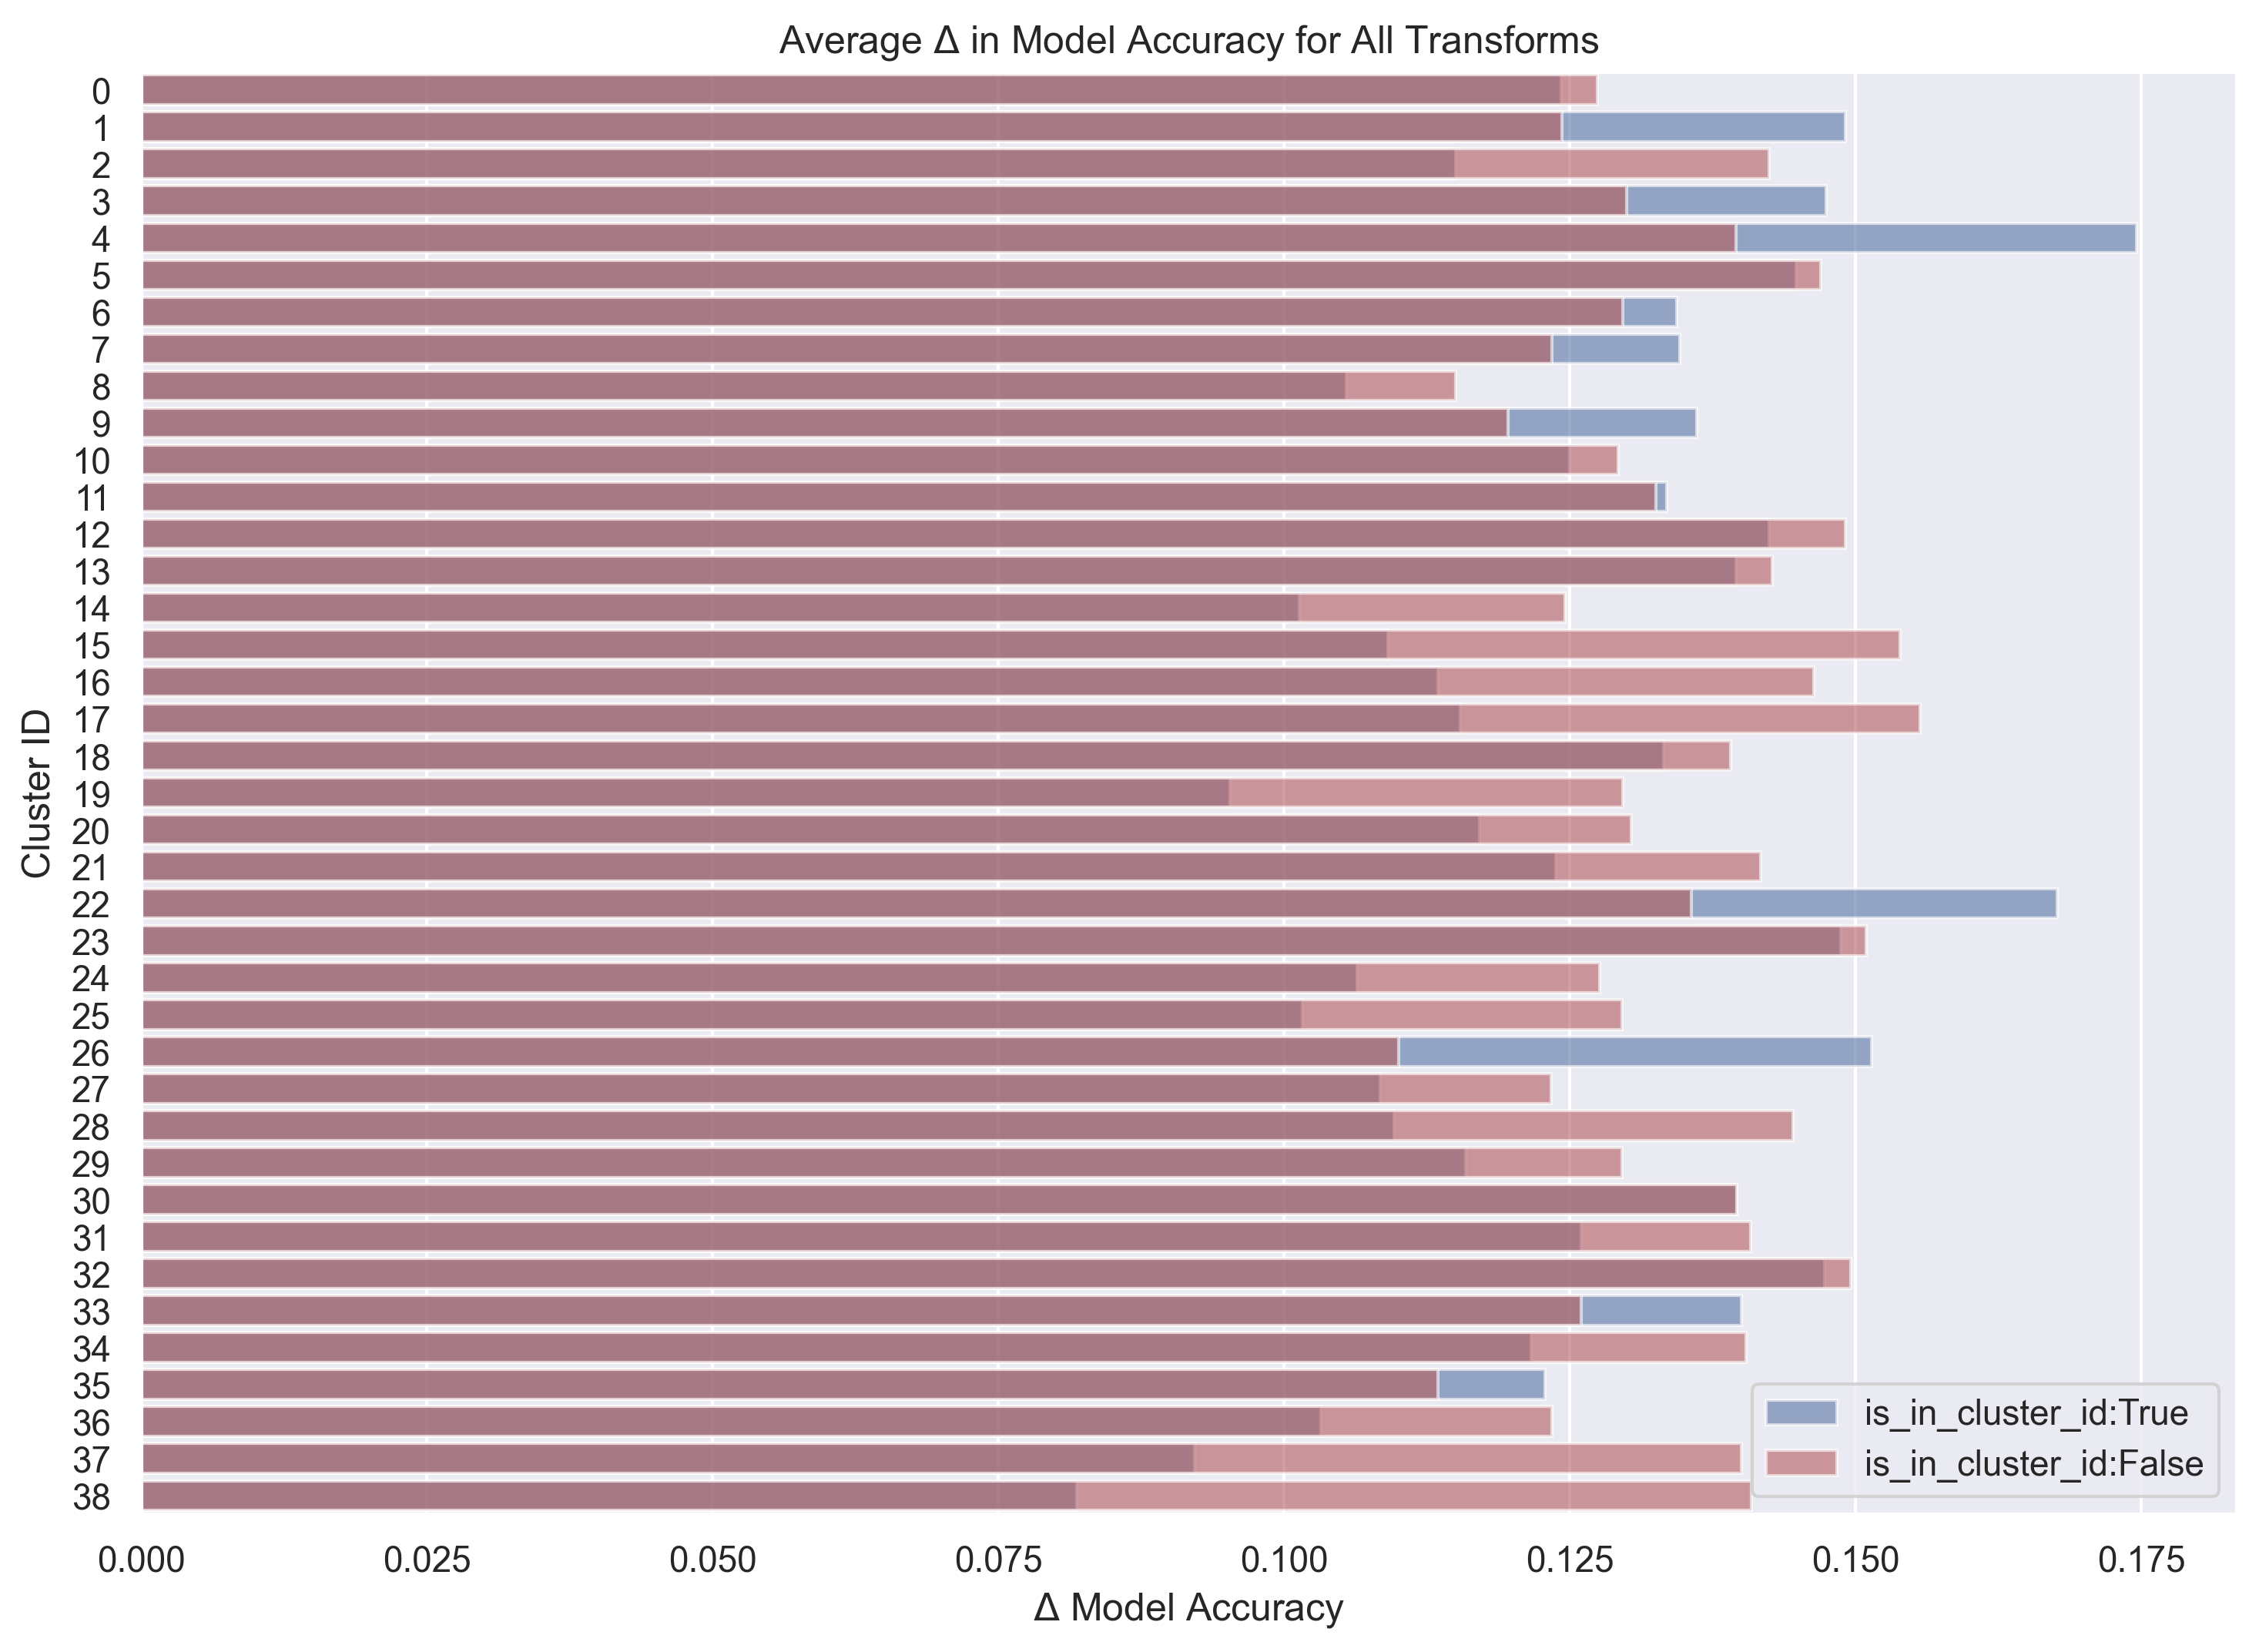

In [165]:
rv.plot_mean_acc_diff_for_all_features()

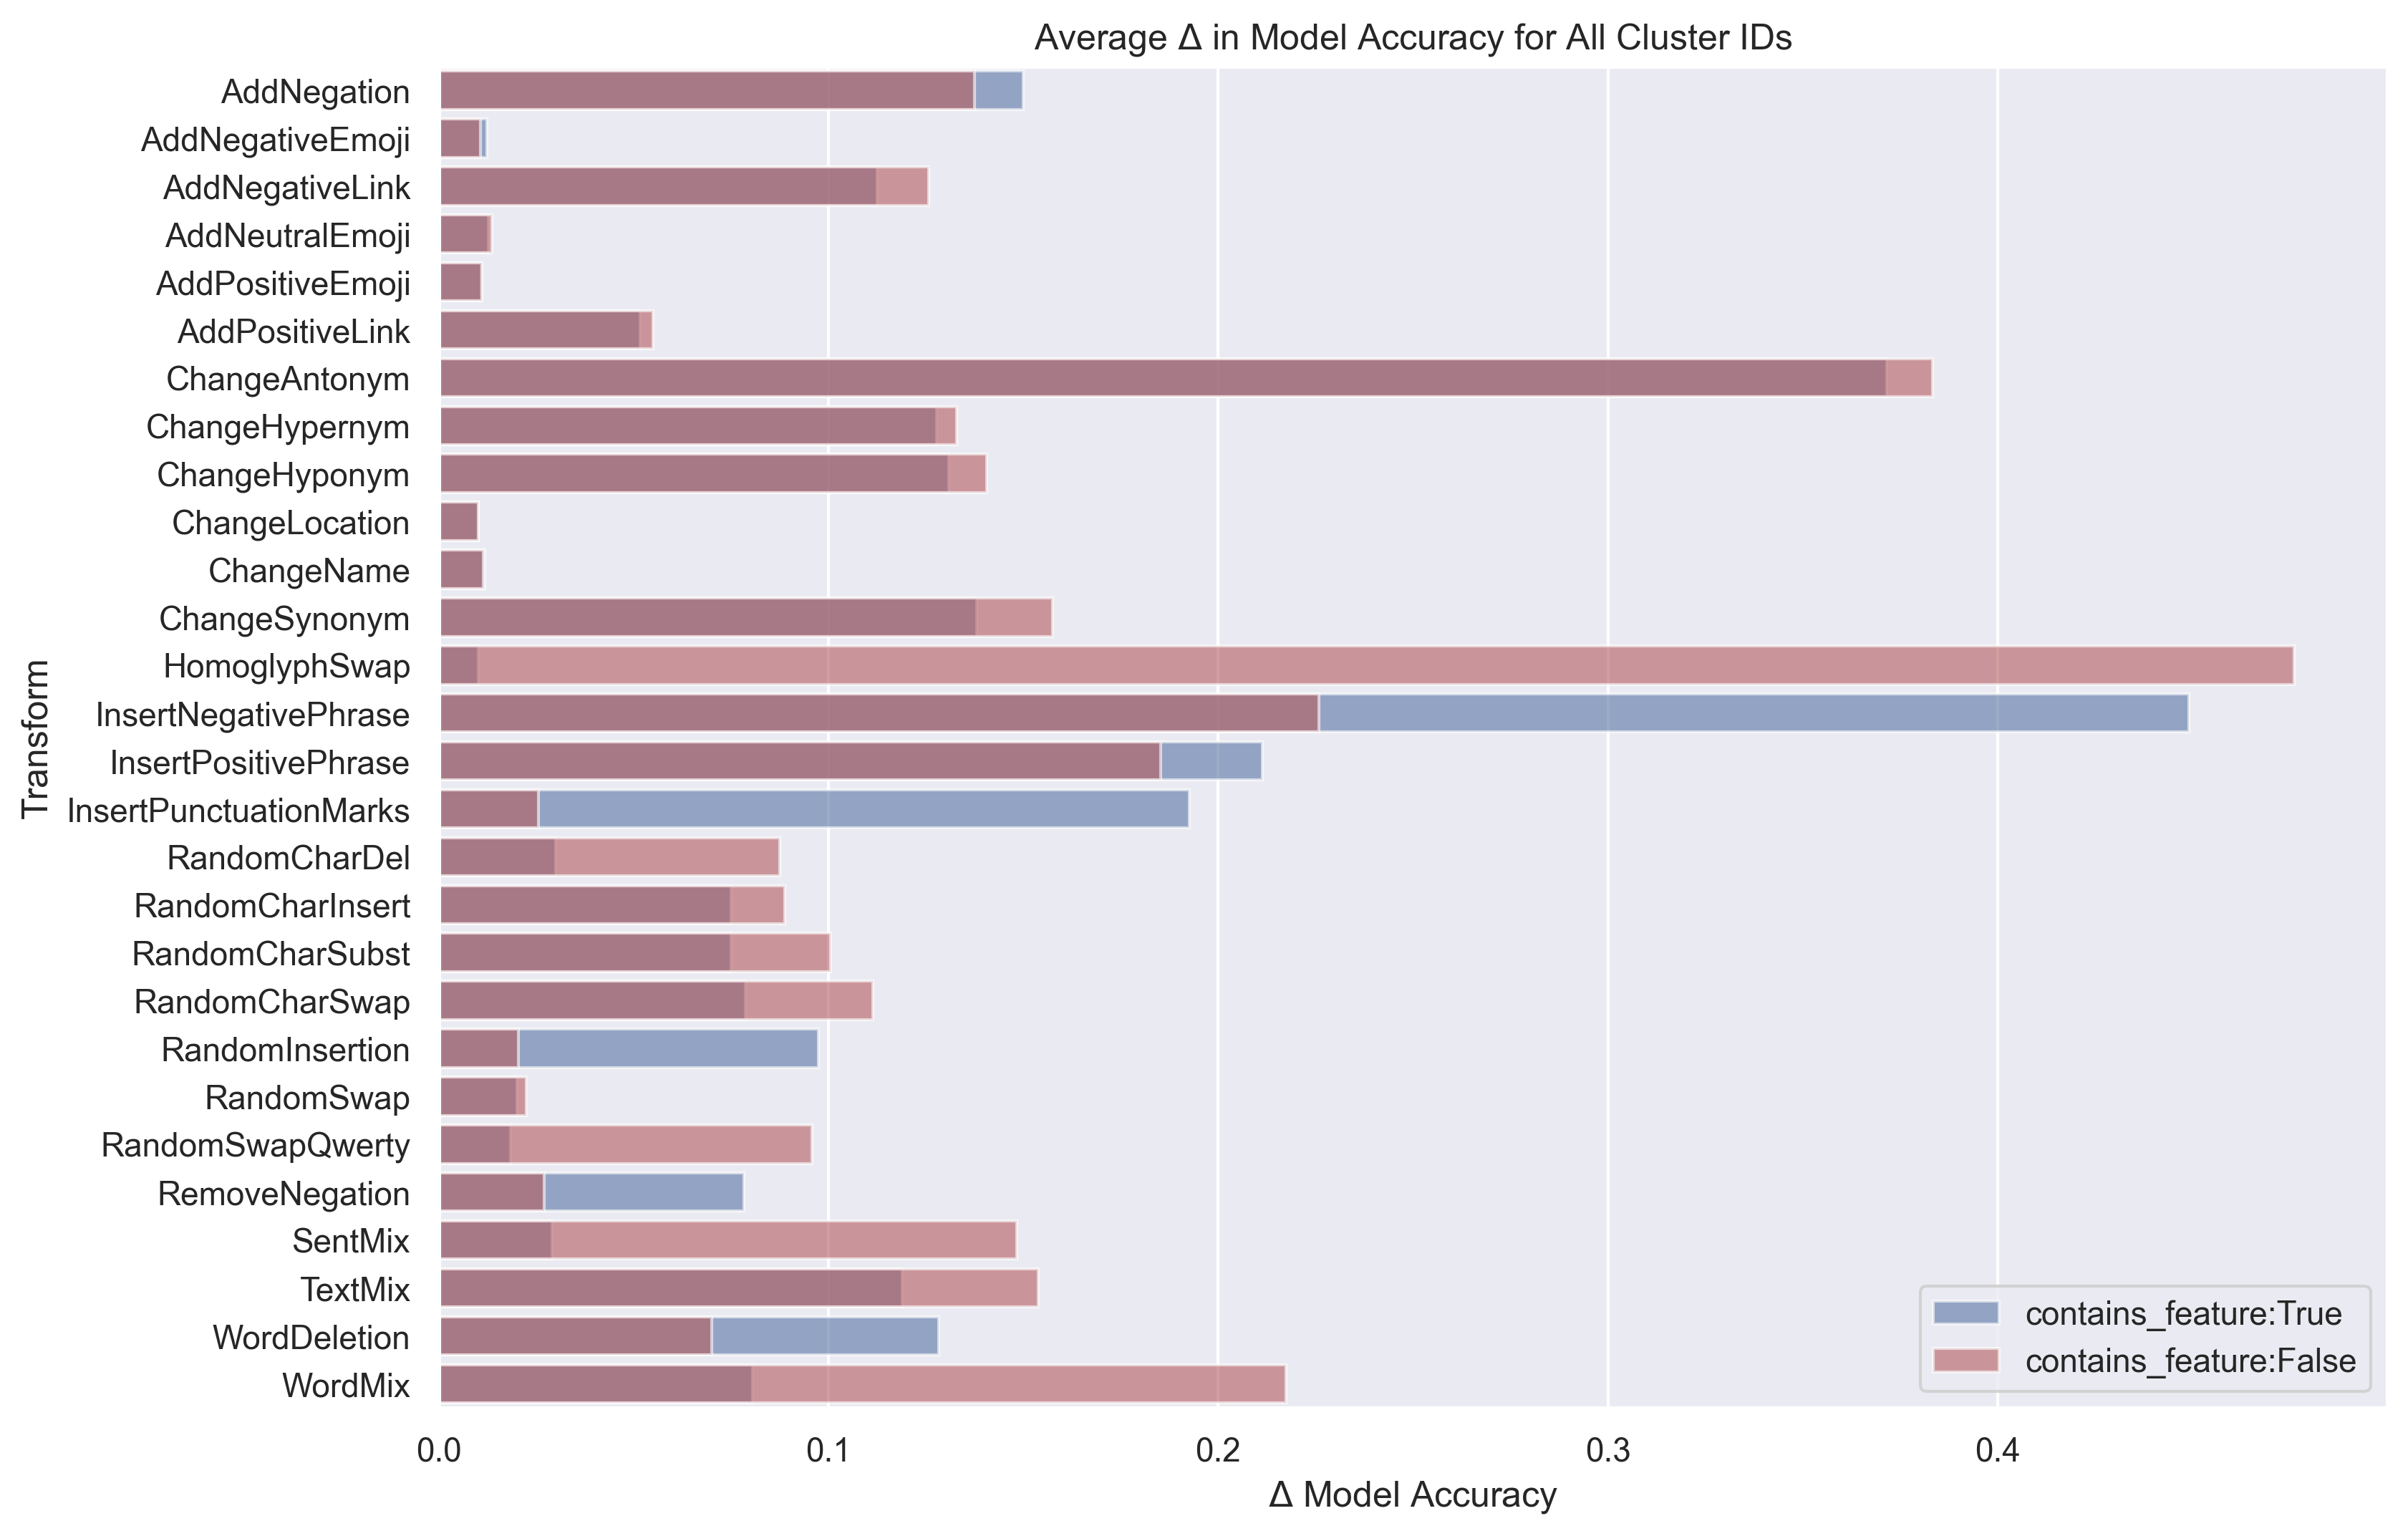

In [161]:
rv.plot_mean_acc_diff_for_all_transforms()

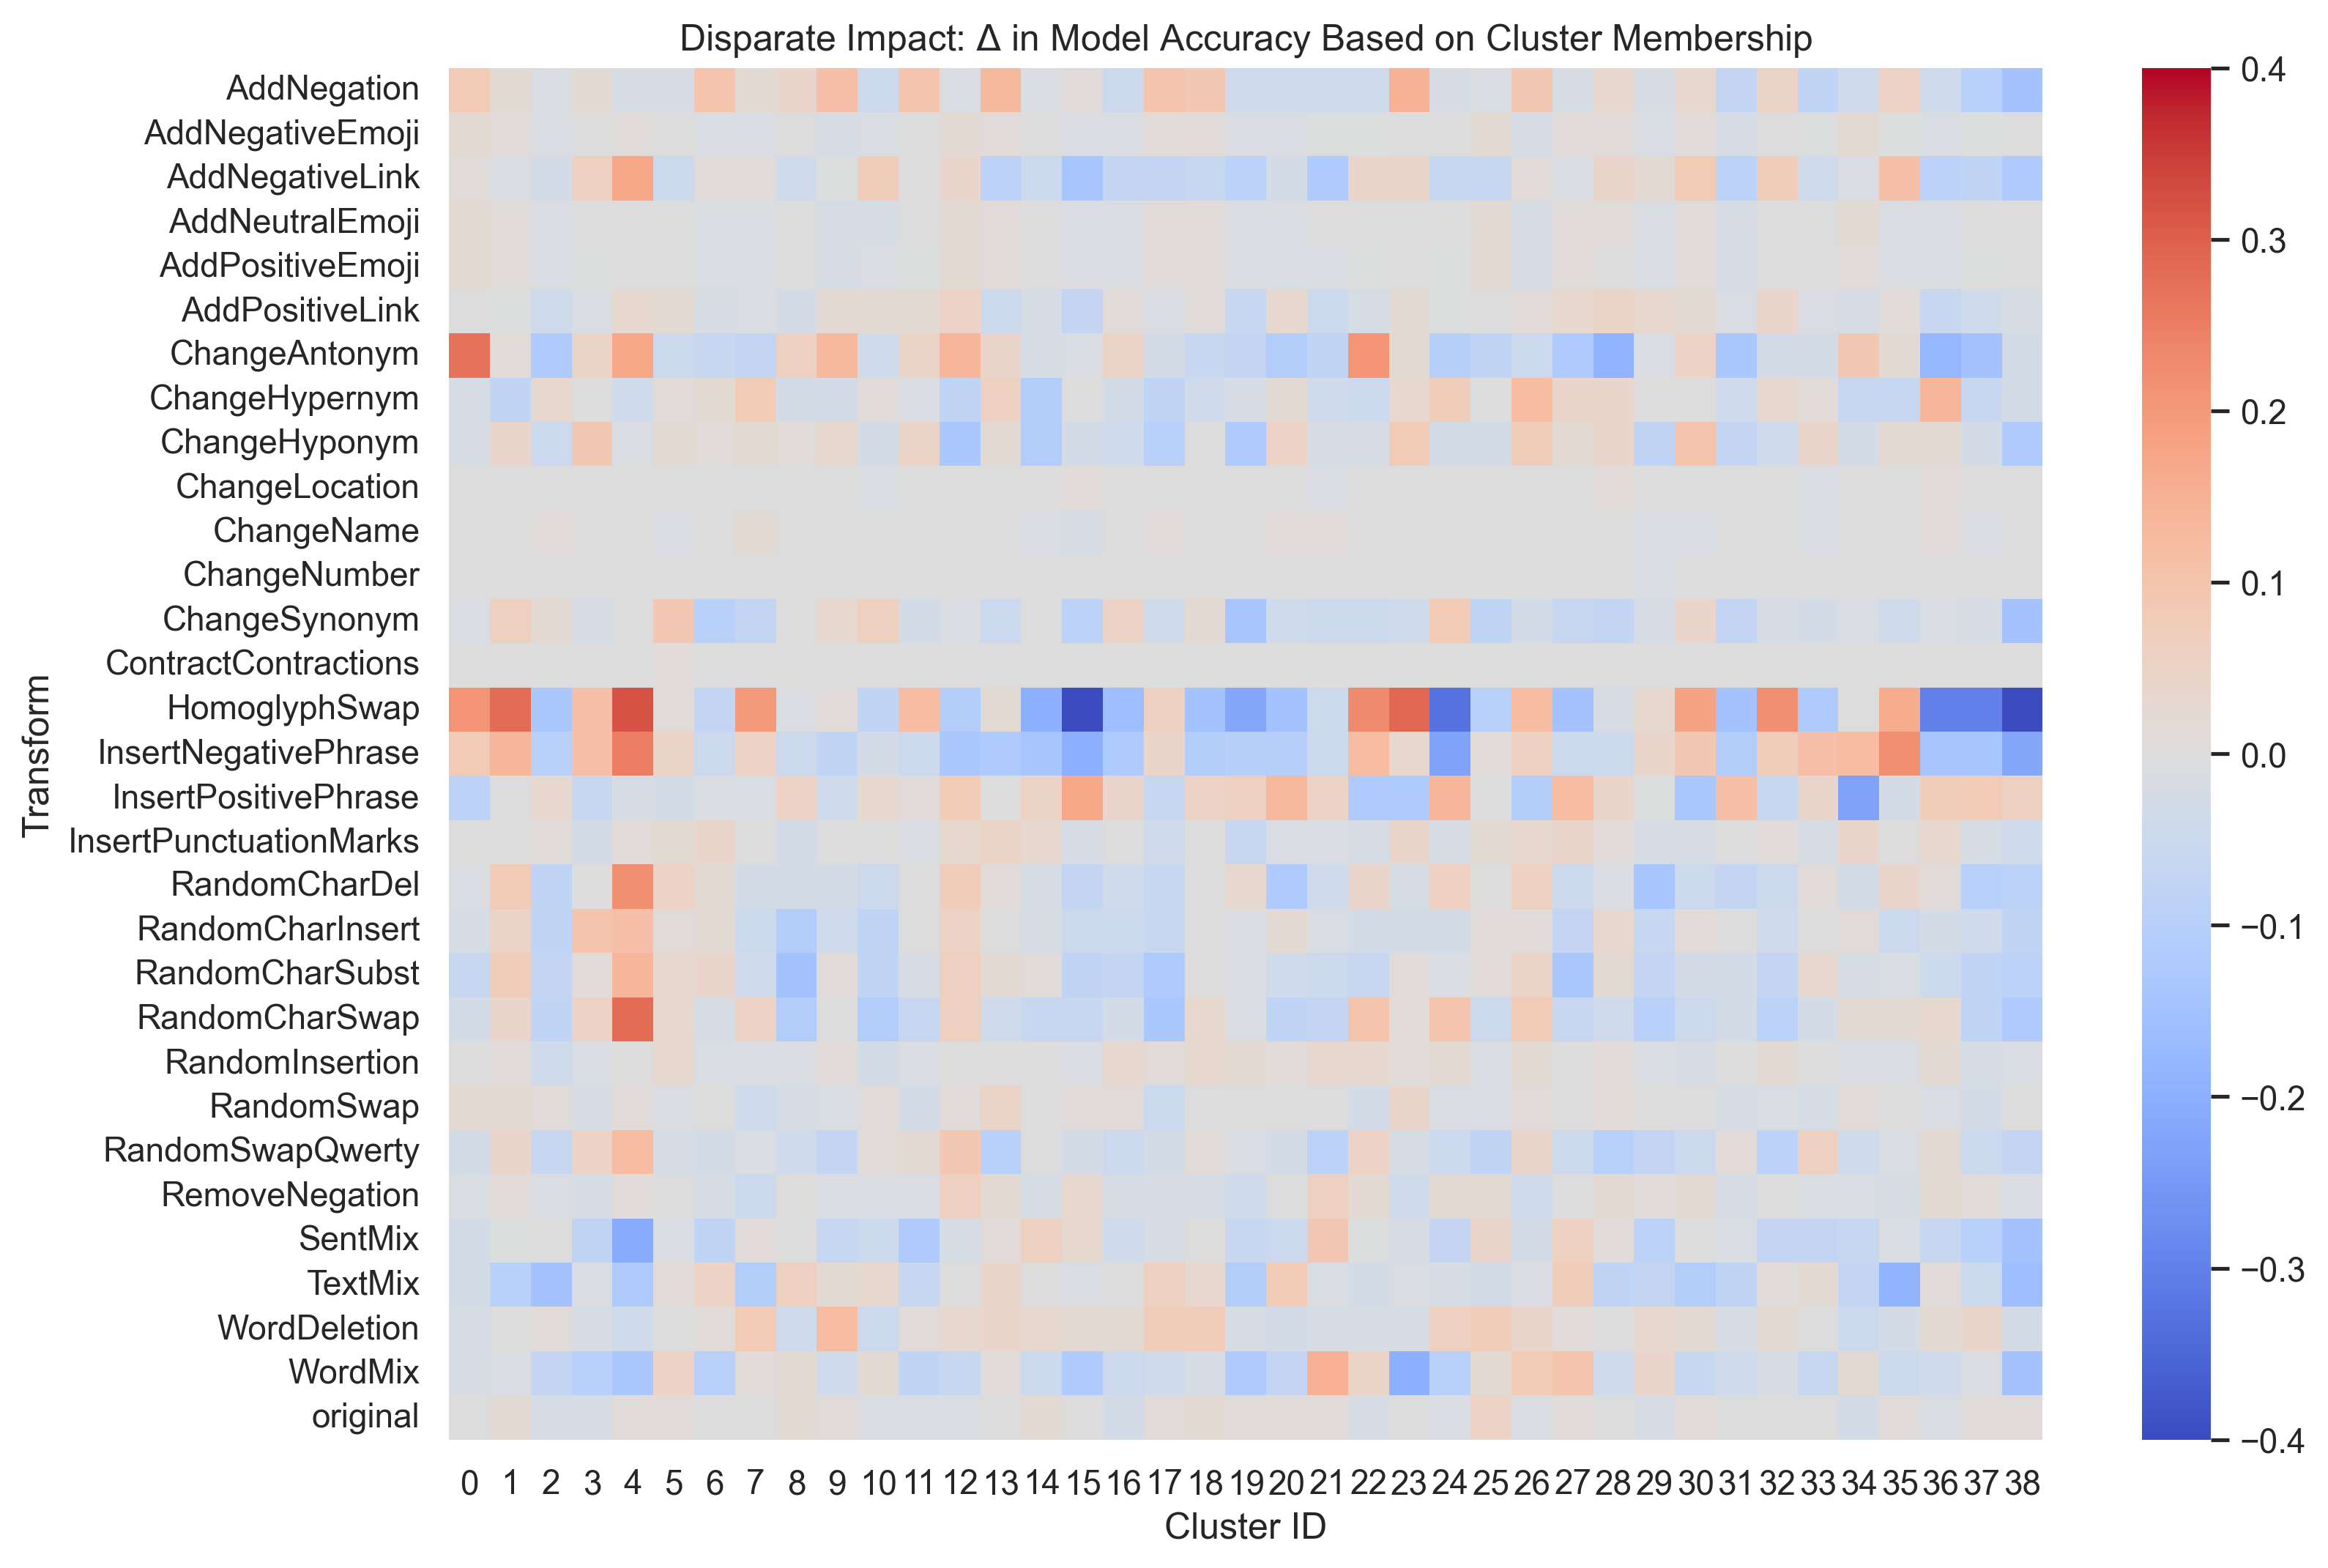

In [162]:
rv.get_disparate_impact_heatmap()